# Multi-Armed Bandits

In [1]:
import numpy as np

from bandits import BernoulliMAB, GaussianMAB
from agents import EpsilonGreedy, UpperConfidenceBound, GradientBandit
from utils import evaluate_agents, ucb_race_chart

## Bandits

There are two bandit types I implemented the `BernoulliMAB` for which you define a probability of returning a reward of 0 or 1 for each arm, and a `GaussianMAB` for which you define a mean and standard deviation of the reward to return for each arm.

### BernoulliMAB


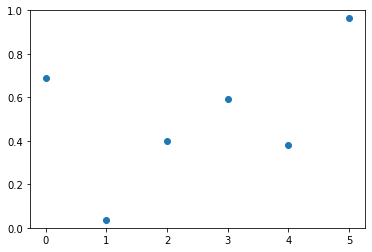

In [14]:
mab = BernoulliMAB([np.random.random() for _ in range(num_arms)])
mab.plot_rewards()

### GaussianMAB

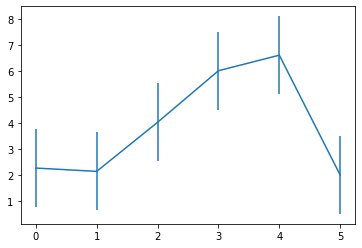

In [19]:
num_arms = 6
max_magnitude = 5
stddev = 1.5
mab = GaussianMAB([(2 + np.random.random() * max_magnitude, stddev) for _ in range(num_arms)])
mab.plot_rewards()

## Agents

### Epsilon Greedy

The epsilon greedy agent is an agent is defined by two parameters: epsilon and epsilon decay. 

Every timestep, the agent generates a random number between 0 and 1, and if the value is below epsilon, then the agent pulls a random arm. Otherwise, it chooses the arm with the highest average reward (breaking ties randomly), thus exploiting what it knows. 

A higher epsilon results in more exploration (random arm selections), anda lower epsilon results in more exploitation.

Because we may not want to keep the same epsilon over the life of our problem, we introduce the epsilon decay parameter, which decreases the value of epsilon after each timestep. This naturally lends itself towards a high explore approach at the beginning when we are unsure of the bandit arm rewards, and a high exploit approach later on once we have more information.

Below is a comparison of some different parameters of epsilon greedy agents:

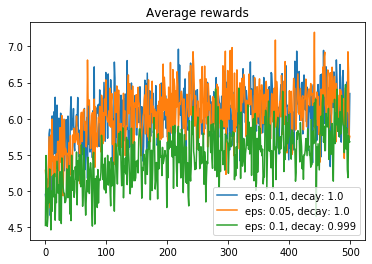

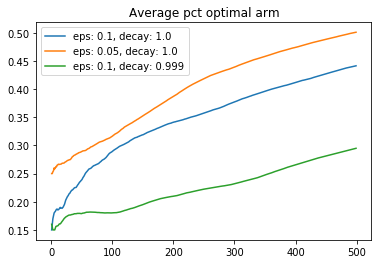

In [22]:
num_arms = 6
max_magnitude = 6
stddev = 3
mab = GaussianMAB([(2 + np.random.random() * max_magnitude, stddev) for _ in range(num_arms)])


agents = [
    EpsilonGreedy(num_arms, epsilon=0.1, base_value=0, epsilon_decay=1.000),
    EpsilonGreedy(num_arms, epsilon=0.05, base_value=0, epsilon_decay=1.000),
    EpsilonGreedy(num_arms, epsilon=0.1, base_value=0, epsilon_decay=0.9999),
]

agent_names = [
    'eps: 0.1, decay: 1.0', 
    'eps: 0.05, decay: 1.0', 
    'eps: 0.1, decay: 0.999'
]

num_runs = 100
num_steps = 500

evaluate_agents(num_runs, num_steps, agents, mab, agent_names)

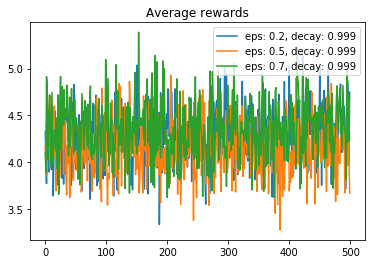

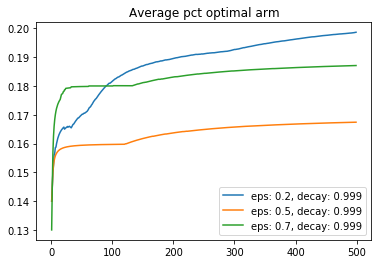

In [25]:
num_arms = 6
max_magnitude = 6
stddev = 3
mab = GaussianMAB([(2 + np.random.random() * max_magnitude, stddev) for _ in range(num_arms)])


agents = [
    EpsilonGreedy(num_arms, epsilon=0.2, base_value=0, epsilon_decay=0.999),
    EpsilonGreedy(num_arms, epsilon=0.2, base_value=0, epsilon_decay=0.99),
    EpsilonGreedy(num_arms, epsilon=0.5, base_value=0, epsilon_decay=0.99),
]

agent_names = [
    'eps: 0.2, decay: 0.999', 
    'eps: 0.5, decay: 0.999', 
    'eps: 0.7, decay: 0.999'
]

num_runs = 100
num_steps = 500

evaluate_agents(num_runs, num_steps, agents, mab, agent_names)

### UCB

The upper confidence bound (UCB) agent tracks the average reward for each agent similar to epsilon greedy, but rather than encoding its exploration as a random chance, it attempts to measure uncertainty in terms of how long it has been since an arm has been chosen.

Each timestep, the agent chooses the arm with the highest average reward plus "uncerainty", and the uncertainty for each arm not chosen increases a little bit. This results in exploration of arms early on, but naturally decreases if a clear winner is found.

An important note is that this uncertainty is not what we normally think of in statistics and is **not related to the variance of the reward estimates**.

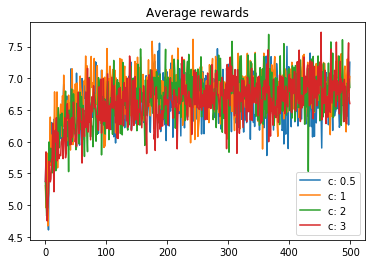

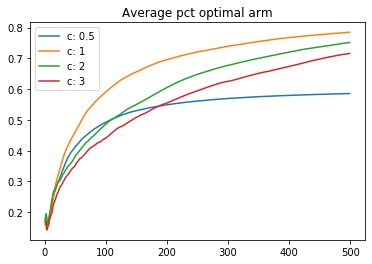

In [27]:
num_arms = 6
max_magnitude = 6
stddev = 3
mab = GaussianMAB([(2 + np.random.random() * max_magnitude, stddev) for _ in range(num_arms)])


agents = [
    UpperConfidenceBound(num_arms, c=0.5),
    UpperConfidenceBound(num_arms, c=1),
    UpperConfidenceBound(num_arms, c=2),
    UpperConfidenceBound(num_arms, c=3)
]

agent_names = [
    'c: 0.5',
    'c: 1',
    'c: 2',
    'c: 3'
]

num_runs = 100
num_steps = 500

evaluate_agents(num_runs, num_steps, agents, mab, agent_names)

One of the main purposes of this repo was to help visualize the UCB agent, in terms of how it balances the average rewards received so far and the uncertainty of unused arms.

Below is as gif of a UCB agent in action. Each frame in the gif is a step where the agent chose an action, received a reward, and updated its estimates/uncertaintities for each arm.

The blue parts of each bar are the average rewards for that arm, and the orange parts are the uncertainty. You should be able to see the blue parts jump around as the highest total blue + orange arm is pulled, while the non-pulled arms' orange parts should steadily increase until they become the highest bars.

At first, the values will most likely jump around more as the variance of the reward estimates is large, but as it progresses, it should settle into selecting a few arms repeatedly until there is one main winner.

![](ucb_video.gif)


### Gradient Agent

The prior two algorithms choose arms based on the average score values, selecting the highest performing one (with some initial exploration). Gradient-based algorithms instead relies on relative preferences for each arm that do not necessarily correspond to actual rewards values. At each timestep, the rewards for an arm are observed, and then an incremental update to the existing preference score is made based on new score and a parameter alpha. This is similar to stochastic gradient ascent, and a larger alpha will result in a larger step size.

The details for updating the preference values $H_{t}(a)$ for selection probabilities $\pi_{t}(a)$ selected action $A_{t}$, rewards $R_{t}$, and average reward $\overline{R_{t}}$ are as follows:

$H_{t+1}(A_{t}) = H_{t}(A_{t}) + \alpha (R_{t} - \overline{R_{t}})(1 - \pi_{t}(A_{t}))$ for action $A_{t}$ and

$H_{t+1}(a) = H_{t}(a) - \alpha (R_{t} - \overline{R_{t}})\pi_{t}(a)$ for other actions $a \neq A_{t}$

When choosing an arm, the agent passes these arm preferences through the softmax distribution to assign weights to all arms that add up to one. These weights are the probabilities that each arm is chosen. After each step, the average rewards are updated, then the weights for sampling are recalculated.

In case you aren't familiar, the softmax distribution is as follows: $ P\{A_{t} = a\} = \frac{e^{H_{t}(a)}}{\sum_{b=1}^k e^{H_{t}(b)}} $

One thing to note is that the average rewards at the start before any weights are input affects the results. Starting all arms out with a value greater than zero will still have an effect of an equal chance for all arms to be selected, but will encourage more exploration in the short term before potentially lowering poorly performing probabilities of being selected almost to zero.

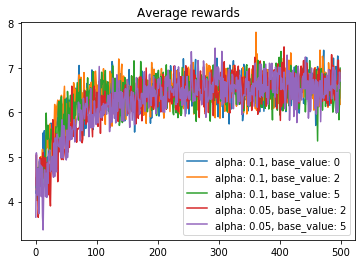

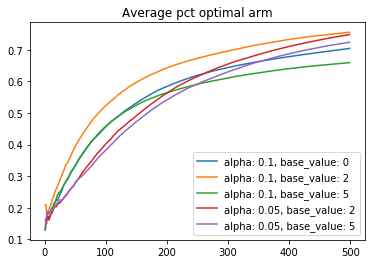

In [28]:
num_arms = 6
max_magnitude = 6
stddev = 3
mab = GaussianMAB([(2 + np.random.random() * max_magnitude, stddev) for _ in range(num_arms)])


agents = [
    GradientBandit(num_arms, alpha=0.1, base_value=0),
    GradientBandit(num_arms, alpha=0.1, base_value=2),
    GradientBandit(num_arms, alpha=0.1, base_value=5),
    GradientBandit(num_arms, alpha=0.05, base_value=2),
    GradientBandit(num_arms, alpha=0.05, base_value=5),
]

agent_names = [
    'alpha: 0.1, base_value: 0',
    'alpha: 0.1, base_value: 2',
    'alpha: 0.1, base_value: 5',
    'alpha: 0.05, base_value: 2',
    'alpha: 0.05, base_value: 5',
]

num_runs = 100
num_steps = 500

evaluate_agents(num_runs, num_steps, agents, mab, agent_names)